Running structure-from-motion on dataset 3
Detecting SIFT features...
Initializing with images 4 and 7...
GRIC Scores -> H: 60201.32 vs F: 22971.77
>>>  result: 3D -> 选择 F
>>> [Init] 判定为立体场景 (Fundamental Matrix)
初始化完成！生成了 3538 个 3D 点。

>>> 开始处理剩余的 10 张图片...

>>> 选中图片 6 (参考图 4, PnP匹配数 2807)
正在与参考图 4 进行三角化扩展点云...
三角化: 候选 1328 -> 过滤后保留 1325 个优质点
正在进行 BA 优化 (Cameras: 3)...
观测数据准备完毕: 12434 条
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2699e-01                                    3.67e+00    
       1              2         2.5148e-01      7.55e-02       2.08e-01       1.11e-01    
       2              3         2.5146e-01      1.98e-05       3.71e-03       2.48e-04    
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 3, initial cost 3.2699e-01, final cost 2.5146e-01, first-order optimality 2.48e-04.
开始优化...
------------------------------
优化是否成功: True
优化终止原因: Both `ftol` and `xto

NameError: name 'p' is not defined

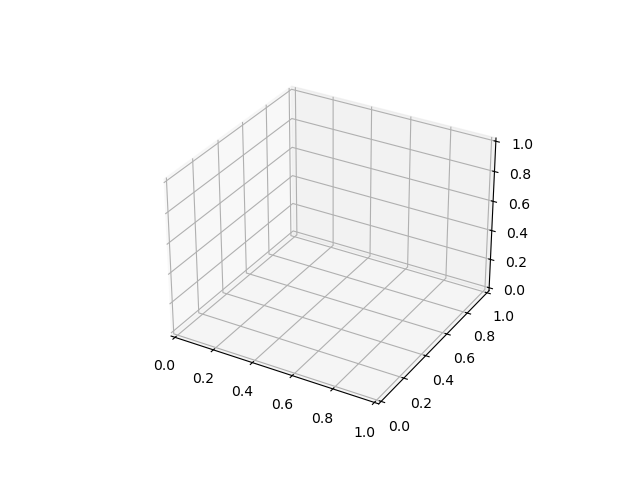

In [2]:
%matplotlib widget  
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from project_helpers import get_dataset_info
import sys
import matplotlib.pyplot as plt
import cv2

# 确保你的 geometry.py 里有这些函数
from geometry import (
    enforce_essential, 
    model_selection, 
    triangulate_3D_point_DLT, 
    run_motion_ba, # 假设你把 BA 也放进去了，或者定义在这个文件上方
    plot_camera,
    clean_point_cloud
)

# =========================================================
# 1. 设置与加载数据
# =========================================================
dataset_id = 3 # Monestary
print(f"Running structure-from-motion on dataset {dataset_id}")
K, img_names, init_pair, pixel_threshold = get_dataset_info(dataset_id)
num_images = len(img_names)

# =========================================================
# 2. 特征提取 (Feature Extraction)
# =========================================================
print("Detecting SIFT features...")
kp_list = []
des_list = []
sift = cv2.SIFT_create(nfeatures=8000)

for img_name in img_names:
    img = cv2.imread(img_name)
    kp, des = sift.detectAndCompute(img, None)
    kp_list.append(kp)
    des_list.append(des)

# 准备全局变量
all_cameras = [None] * num_images # 存 P 矩阵 (3x4)
image_map = [{} for _ in range(num_images)] # 存 2D-3D 映射 {feat_idx: 3d_idx}
X_recon = np.zeros((4, 0)) # 3D 点云 (4, N)
done_indices = [] # 已注册的图片索引

# =========================================================
# 3. 初始化 (Initialization) - Image 0 & 8
# =========================================================
idx0 = init_pair[0]
idx8 = init_pair[1]
print(f"Initializing with images {idx0} and {idx8}...")

# 3.1 匹配
bf = cv2.BFMatcher()
matches = bf.knnMatch(des_list[idx0], des_list[idx8], k=2)
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

pts1 = np.float32([kp_list[idx0][m.queryIdx].pt for m in good_matches]) # (N, 2)
pts2 = np.float32([kp_list[idx8][m.trainIdx].pt for m in good_matches]) # (N, 2)

# 3.2 🔥 Model Selection (H vs F)
# 注意：model_selection 接收 (N, 2)
model_type, M, mask = model_selection(pts1, pts2, K)

R_final, t_final = None, None
final_mask = None

if model_type == 'F':
    print(">>> [Init] 判定为立体场景 (Fundamental Matrix)")
    E = K.T @ M @ K
    E = enforce_essential(E)
    # 这里的 mask_pose 才是最准的
    _, R_final, t_final, mask_pose = cv2.recoverPose(E, pts1, pts2, K)
    final_mask = (mask_pose.ravel() > 0)
else:
    print(">>> [Init] 判定为平面场景 (Homography Matrix)")
    H = M
    num_sol, Rs, ts, normals = cv2.decomposeHomographyMat(H, K)
    R_final = Rs[0]
    t_final = ts[0]
    t_final = t_final / (np.linalg.norm(t_final) + 1e-9)
    # H 模式用 model_selection 返回的 mask
    final_mask = (mask.ravel() > 0)

# 3.3 存入相机
all_cameras[idx0] = np.eye(3, 4)
all_cameras[idx8] = np.hstack((R_final, t_final))
done_indices = [idx0, idx8]

# 3.4 初始三角化 (Initial Triangulation)
# 准备归一化坐标
pts1_in = pts1[final_mask].T # (2, M)
pts2_in = pts2[final_mask].T # (2, M)

x0_h = np.vstack([pts1_in, np.ones((1, pts1_in.shape[1]))])
x8_h = np.vstack([pts2_in, np.ones((1, pts2_in.shape[1]))])

K_inv = np.linalg.inv(K)
x0n = K_inv @ x0_h
x8n = K_inv @ x8_h

P0 = np.eye(3, 4)
P8 = np.hstack((R_final, t_final))

X_init = np.zeros((4, x0n.shape[1]))
for i in range(x0n.shape[1]):
    X_init[:, i] = triangulate_3D_point_DLT(x0n[:, i], x8n[:, i], P0, P8)

X_recon = X_init

# 3.5 建立初始 Image Map
inlier_indices = np.where(final_mask)[0]
for col_idx, original_idx in enumerate(inlier_indices):
    m = good_matches[original_idx]
    image_map[idx0][m.queryIdx] = col_idx
    image_map[idx8][m.trainIdx] = col_idx

print(f"初始化完成！生成了 {X_recon.shape[1]} 个 3D 点。")

# =========================================================
# 4. 增量式重建循环 (Incremental SfM Loop)
# =========================================================
print(f"\n>>> 开始处理剩余的 {num_images - 2} 张图片...")

while len(done_indices) < num_images:
    
    # -----------------------------------------------------
    # Step 1: 寻找最佳视角的下一张图片 (Best Next Image)
    # -----------------------------------------------------
    best_image_idx = -1
    max_matches = 0
    
    best_2d = []        # 给 PnP 用
    best_3d = []        # 给 PnP 用
    best_2d_indices = [] # 原始特征点索引 (更新 map 用)
    best_3d_indices = [] # 3D 点索引 (更新 map 用)
    
    best_ref_img = -1   # 用于后续三角化的参考图
    
    for i in range(num_images):
        if i in done_indices: continue 

        curr_2d, curr_3d = [], []
        curr_2d_idx, curr_3d_idx = [], []
        match_counts = {} # 记录这张图 i 跟每个老图 j 匹配了多少个点

        for j in done_indices:
            bf = cv2.BFMatcher()
            raw_matches = bf.knnMatch(des_list[i], des_list[j], k=2)
            
            count_j = 0
            for m, n in raw_matches:
                if m.distance < 0.75 * n.distance:
                    # 链式法则: i -> j -> 3D
                    if m.trainIdx in image_map[j]:
                        p3d_idx = image_map[j][m.trainIdx]
                        
                        if m.queryIdx not in curr_2d_idx:
                            curr_2d.append(kp_list[i][m.queryIdx].pt)
                            curr_3d.append(X_recon[:3, p3d_idx])
                            curr_2d_idx.append(m.queryIdx)
                            curr_3d_idx.append(p3d_idx)
                            count_j += 1
            
            if count_j > 0:
                match_counts[j] = count_j

        if len(curr_2d) > max_matches:
            max_matches = len(curr_2d)
            best_image_idx = i
            best_2d = np.array(curr_2d, dtype=np.float32)
            best_3d = np.array(curr_3d, dtype=np.float32)
            best_2d_indices = curr_2d_idx
            best_3d_indices = curr_3d_idx
            # 找到匹配最多的那张老图作为参考
            if match_counts:
                best_ref_img = max(match_counts, key=match_counts.get)

    if max_matches < 6:
        print("警告：没有足够的匹配点来进行 PnP，停止重建。")
        break
        
    print(f"\n>>> 选中图片 {best_image_idx} (参考图 {best_ref_img}, PnP匹配数 {max_matches})")

    # -----------------------------------------------------
    # Step 2: PnP 注册新相机
    # -----------------------------------------------------
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        best_3d, best_2d, K, None, 
        flags=cv2.SOLVEPNP_ITERATIVE,
        reprojectionError=4.0, confidence=0.99
    )
    
    if not success:
        print("PnP 求解失败，跳过。")
        continue

    R, _ = cv2.Rodrigues(rvec)
    t = tvec
    all_cameras[best_image_idx] = np.hstack((R, t))
    done_indices.append(best_image_idx)
    
    # 更新 image_map (PnP 用到的点)
    if inliers is not None:
        for k in inliers.ravel():
            # best_2d_indices[k] 是图 best_image_idx 上的特征点 ID
            # best_3d_indices[k] 是对应的 3D 点列号
            image_map[best_image_idx][best_2d_indices[k]] = best_3d_indices[k]

   
 # -----------------------------------------------------
    # Step 3: 三角化新点 (Triangulate New Points)
    # 这就是把你原来的代码逻辑搬过来了
    # -----------------------------------------------------
    # Step 3: 三角化新点 (带 Outlier 剔除)
    # -----------------------------------------------------
    if best_ref_img != -1:
        print(f"正在与参考图 {best_ref_img} 进行三角化扩展点云...")
        
        bf = cv2.BFMatcher()
        new_matches = bf.knnMatch(des_list[best_image_idx], des_list[best_ref_img], k=2)
        
        pts_new_curr = []
        pts_new_ref = []
        matches_obj = []
        
        for m, n in new_matches:
            if m.distance < 0.70 * n.distance: # 稍微严格一点 Ratio Test (0.75 -> 0.70)
                idx_curr = m.queryIdx
                idx_ref = m.trainIdx
                
                # 只有当两个点都还没有对应 3D 点时，才三角化
                if (idx_curr not in image_map[best_image_idx]) and \
                   (idx_ref not in image_map[best_ref_img]):
                    
                    pts_new_curr.append(kp_list[best_image_idx][idx_curr].pt)
                    pts_new_ref.append(kp_list[best_ref_img][idx_ref].pt)
                    matches_obj.append(m)
        
        if len(pts_new_curr) > 0:
            # 1. 准备数据
            pts_new_curr = np.array(pts_new_curr).T 
            pts_new_ref = np.array(pts_new_ref).T   
            
            # 2. 三角化
            P_curr = all_cameras[best_image_idx]
            P_ref = all_cameras[best_ref_img]
            
            # 归一化输入
            x_curr_n = K_inv @ np.vstack([pts_new_curr, np.ones((1, pts_new_curr.shape[1]))])
            x_ref_n = K_inv @ np.vstack([pts_new_ref, np.ones((1, pts_new_ref.shape[1]))])
            
            X_candidates = np.zeros((4, pts_new_curr.shape[1]))
            for k in range(pts_new_curr.shape[1]):
                X_candidates[:, k] = triangulate_3D_point_DLT(x_curr_n[:, k], x_ref_n[:, k], P_curr, P_ref)
            
            # ==========================================================
            # 🔥 关键修改：过滤垃圾点 (Filter Outliers) 🔥
            # ==========================================================
            
            # A. 检查深度 (必须在相机前面)
            # 把点投影到当前相机坐标系
            X_cam = P_curr @ X_candidates
            mask_depth = X_cam[2, :] > 0  # Z > 0
            
            # B. 检查重投影误差 (Reprojection Error)
            # 投影回当前图
            proj_curr = X_cam[:2, :] / (X_cam[2, :] + 1e-9)
            # 投影回参考图
            X_ref = P_ref @ X_candidates
            proj_ref = X_ref[:2, :] / (X_ref[2, :] + 1e-9)
            # Z也必须在参考图前面
            mask_depth &= (X_ref[2, :] > 0)

            # 计算像素误差 (Pixel Error)
            # 注意：这里对比的是 归一化平面上的点，我们需要乘 K 变回像素坐标来比吗？
            # 实际上 triangulate 输入的是归一化坐标，所以投影回来也是归一化坐标。
            # 为了方便，我们直接在归一化平面上比，阈值设小一点 (比如 4/f 约等于 0.005)
            # 或者，更直观的方法：把 2D 点也乘 K_inv 变成归一化坐标比
            
            dist_curr = np.sum((proj_curr - x_curr_n[:2, :])**2, axis=0)
            dist_ref = np.sum((proj_ref - x_ref_n[:2, :])**2, axis=0)
            
            # 设定阈值：例如误差平方和 < 0.005 (对应像素约 2~3 pixel)
            limit = 0.005 
            mask_error = (dist_curr < limit) & (dist_ref < limit)
            
            # C. 综合掩码
            valid_mask = mask_depth & mask_error
            
            # 3. 只保留好点
            X_good = X_candidates[:, valid_mask]
            
            if X_good.shape[1] > 0:
                start_idx = X_recon.shape[1]
                X_recon = np.hstack([X_recon, X_good])
                
                # 只更新好点的 Map
                # 注意：matches_obj 和 X_candidates 是一一对应的
                # 我们需要用 valid_mask 来筛选 matches_obj
                good_indices = np.where(valid_mask)[0]
                
                for k in good_indices:
                    m = matches_obj[k]
                    # 计算在 X_recon 中的新位置
                    # 这里的逻辑稍微复杂点：X_good 的第 j 个点，对应 valid_mask 里的第 k 个 True
                    # 我们可以简单地用一个计数器
                    pass 

                # 重新写映射循环，更清晰一点
                count_added = 0
                for i, is_good in enumerate(valid_mask):
                    if is_good:
                        m = matches_obj[i]
                        new_3d_idx = start_idx + count_added
                        image_map[best_image_idx][m.queryIdx] = new_3d_idx
                        image_map[best_ref_img][m.trainIdx] = new_3d_idx
                        count_added += 1
                
                print(f"三角化: 候选 {X_candidates.shape[1]} -> 过滤后保留 {count_added} 个优质点")
            else:
                print("没有合格的新点被添加。")
          

    # -----------------------------------------------------
    # Step 4: BA 优化
    # -----------------------------------------------------
    print(f"正在进行 BA 优化 (Cameras: {len(done_indices)})...")
    # 如果 run_motion_ba 需要把 all_cameras 转 list 再转回来，这里注意一下
    all_cameras = run_motion_ba( X_recon, all_cameras,image_map, K, kp_list)

print("\n🎉 重建全部完成！")

# =========================================================
# 5. 可视化 (可选)
# =========================================================
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# 画点云 (随机采样一下，不然太卡)
step = 10
X_final = clean_point_cloud(X_recon, distance_threshold_scale=1.5)
ax.scatter(X_final[0, :], X_final[1, :], X_final[2, :], s=1, c='k', marker='.')

# 画相机
for i in done_indices:
    plot_camera(all_cameras[i], scale=0.5,ax=ax)

plt.show()

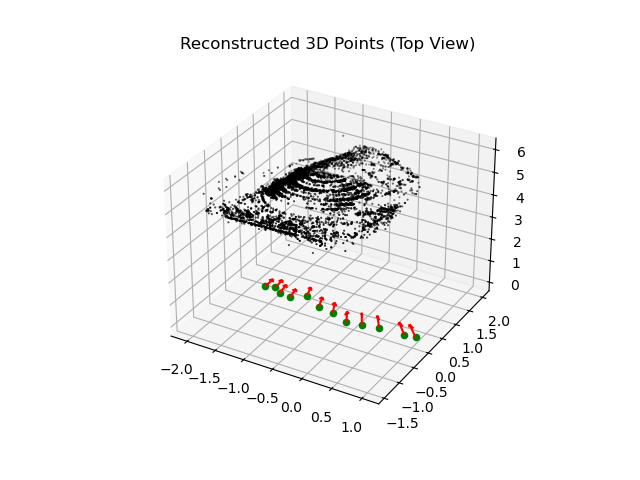

In [3]:
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.set_title('Reconstructed 3D Points (Top View)')
ax.scatter(X_final[0, :], X_final[1, :],X_final[2,:], s=1, c='k', marker='.')
for i in done_indices:
    plot_camera(all_cameras[i], scale=0.5,ax=ax)

plt.show()


In [3]:
dataset_id=2
print("Running structure-from-motion on dataset", dataset_id)
K, img_names, init_pair, pixel_threshold=get_dataset_info(dataset_id)
print("Intrinsic calibration K:\n", K)
sift=cv2.SIFT_create()
kp_list=[]
des_list=[]

for name in img_names:
    img=cv2.imread(name)
    kp, des=sift.detectAndCompute(img,None)
    kp_list.append(kp)
    des_list.append(des)

# img0 = cv2.imread(img_names[init_pair[0]]) # 这行可以留着，也许后面画图要用
# img8 = cv2.imread(img_names[init_pair[1]]) # 这行也可以留着

Running structure-from-motion on dataset 2
Intrinsic calibration K:
 [[2.37851429e+03 0.00000000e+00 9.68000000e+02]
 [0.00000000e+00 2.37851429e+03 6.48000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [4]:
print("Detecting SIFT features")

idx0=init_pair[0]
idx8=init_pair[1]

kp0=kp_list[idx0]
des0=des_list[idx0]

kp8=kp_list[idx8]
des8=des_list[idx8]
print("Matching SIFT features")
bf=cv2.BFMatcher()
matches=bf.knnMatch(des0,des8,k=2)
# Lowe's Ratio Test
good_matches=[]
for m,n in matches:
    if m.distance<0.75*n.distance:
        good_matches.append(m)
print("Good matches:",len(good_matches))

pts1 = np.float32([kp0[m.queryIdx].pt for m in good_matches]).T
pts2=np.array([kp8[m.trainIdx].pt for m in good_matches]).T

model_type,M,mask= model_selection(pts1.T, pts2.T, K)
if model_type=='F':
    print("Estimated model: Fundamental matrix")
    E=K.T @ M @ K
    E=enforce_essential(E)
    print("Converted to Essential matrix:\n", E)
    retval, R, t, mask_pose = cv2.recoverPose(E, pts1.T, pts2.T, K)
    
    R_final = R
    t_final = t
else:
    print("Homography model:Homography matrix")
    H=M
    num_sol,Rs,ts,normals=cv2.decomposeHomographyMat(H,K)

    R_final = Rs[0]
    t_final = ts[0]
    
    t_final = t_final / (np.linalg.norm(t_final) + 1e-9)

x0 = np.vstack([pts1, np.ones((1, pts1.shape[1]))])
x8 = np.vstack([pts2, np.ones((1, pts2.shape[1]))])


Detecting SIFT features
Matching SIFT features
Good matches: 2108
GRIC Scores -> H: 31333.84 vs F: 15814.29
>>>  result: 3D -> 选择 F
Estimated model: Fundamental matrix
Converted to Essential matrix:
 [[ 0.00680158  0.09690836 -0.04209883]
 [ 0.37166978  0.01020523 -0.92732188]
 [-0.09441072  0.99055716 -0.02246929]]


In [5]:
#Inverse Calibration
x0n=np.linalg.inv(K)@x0
x8n=np.linalg.inv(K)@x8
#running RANSAC
# pixel_threshold_n=pixel_threshold/K[0,0]* N1[0, 0]
# E_hat,inliers,errs,iters=estimate_E_robust(x0_n,x8_n,pixel_threshold_n)
# print("RANSAC iters:",iters)
# print(f"Inliers: {np.sum(inliers)}/{len(inliers)}")

# E=N2.T@E_hat@N1
# E=enforce_essential(E)
# print("Estimated Essential Matrix:\n", E)
# P8_candidates=extract_P_from_E(E)


In [6]:
# x0_good=x0n[:,inliers]
# x8_good=x8n[:,inliers]
# best_ind,P8_best=check_cheirality(P8_candidates,x0_good,x8_good)
# print("Selected P2 candidate index:", best_ind+1)
# print("Estimated P2:\n", P8_best)
if model_type=="F":
    final_mask=(mask_pose.ravel()>0)
else:
    final_mask=(mask.ravel()>0)
x0n_inliers=x0n[:,final_mask]
x8n_inliers=x8n[:,final_mask]

In [7]:
#Reconstruct 3D points
P0=np.hstack([np.eye(3),np.zeros((3,1))])
P8=np.hstack([R_final,t_final])
num_points=x0n_inliers.shape[1]
X_recon=np.zeros((4,num_points))
for i in range(num_points):
    X_recon[:,i]=triangulate_3D_point_DLT(x0n_inliers[:,i],x8n_inliers[:,i],P0,P8)

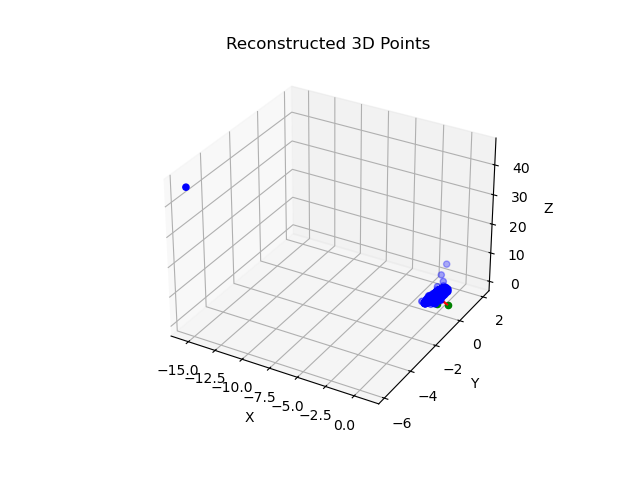

In [8]:
#Visualize 3D points
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.scatter(X_recon[0,:],X_recon[1,:],X_recon[2,:],c='b',marker='o')
plot_camera(P0, scale=1.0, ax=ax)
plot_camera(P8, scale=1.0, ax=ax)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Reconstructed 3D Points')
plt.show()

In [9]:
#Resrctioning
image0_map={}
image8_map={}
valid_indices=np.where(final_mask)[0]
for col_ind, match_ind in enumerate(valid_indices):
    m=good_matches[match_ind]
    image0_map[m.queryIdx]=col_ind
    image8_map[m.trainIdx]=col_ind
print(f"Mapped {len(image0_map)} points from Image 0 to 3D cloud.")
print(f"Mapped {len(image8_map)} points from Image 8 to 3D cloud.")


num_images=len(img_names)
all_cameras=[None]*num_images
all_cameras[idx0]=P0
all_cameras[idx8]=P8

image_map=[{} for _ in range(num_images)]
image_map[idx0]=image0_map
image_map[idx8]=image8_map

done_indices=[idx0,idx8]

print("initialized with images:", done_indices)

max_image=num_images
while len(done_indices)<num_images:
    print("seek for next image to add...")

    best_image_idx=-1
    max_2d3d_matches=0
    best_2d_points=[]
    best_3d_points=[]
    best_2d_indices=[]
    
    for i in range(num_images):
        if i in done_indices:
            continue
        current_2d=[]
        current_3d=[]
        current_indices=[]

        for j in done_indices:
            matches_ij=bf.knnMatch(des_list[i],des_list[j],k=2)
            good_matches_ij=[]
            for m,n in matches_ij:
                if m.distance<0.75*n.distance:
                    good_matches_ij.append(m)
            for m in good_matches_ij:
                idx_in_i=m.queryIdx
                idx_in_j=m.trainIdx
                if idx_in_j in image_map[j]:
                    point_3d_ind=image_map[j][idx_in_j]
                    if idx_in_i not in current_indices:
                        current_2d.append(kp_list[i][idx_in_i].pt)
                        current_3d.append(X_recon[:,point_3d_ind])
                        current_indices.append(idx_in_i)
        if len(current_2d)>max_2d3d_matches:
            max_2d3d_matches=len(current_2d)
            best_image_idx=i
            best_2d_points=current_2d
            best_3d_points=current_3d
            best_2d_indices=current_indices
    print(f"Best next image to add: {best_image_idx} with {max_2d3d_matches} 2D-3D matches.")
    if max_2d3d_matches<6:
        print("Not enough 2D-3D matches, stopping.")
        break
        

Mapped 2108 points from Image 0 to 3D cloud.
Mapped 2084 points from Image 8 to 3D cloud.
initialized with images: [0, 8]
seek for next image to add...
Best next image to add: 6 with 1691 2D-3D matches.
seek for next image to add...
Best next image to add: 6 with 1691 2D-3D matches.
seek for next image to add...
Best next image to add: 6 with 1691 2D-3D matches.
seek for next image to add...
Best next image to add: 6 with 1691 2D-3D matches.
seek for next image to add...
Best next image to add: 6 with 1691 2D-3D matches.
seek for next image to add...
Best next image to add: 6 with 1691 2D-3D matches.
seek for next image to add...
Best next image to add: 6 with 1691 2D-3D matches.
seek for next image to add...


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002AD665228B0>>
Traceback (most recent call last):
  File "c:\Users\wangye\.conda\envs\computer_vision\lib\site-packages\ipykernel\ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:

registered_order=[1,2,3,4,5,6,7]

for curr_idx in registered_order:
    pre_idx=curr_idx-1

    kp_pre=kp_list[pre_idx]
    des_pre=des_list[pre_idx]

    kp_curr=kp_list[curr_idx]
    des_curr=des_list[curr_idx] 
    matches_curr=bf.knnMatch(des_pre,des_curr,k=2)
    good_matches_curr=[]
    for m,n in matches_curr:
        if m.distance<0.75*n.distance:
            good_matches_curr.append(m)
    pts2D_curr = []
    pts3D_curr = []
    pnp_matches_list = []
    matches_triangulate=[]
    pre_map=image_map[pre_idx]
    for m in good_matches_curr:
        if m.queryIdx in pre_map:
              idx_3D=pre_map[m.queryIdx]
              X=X_recon[:,idx_3D]
              pts3D_curr.append(X)
              pts2D=kp_curr[m.trainIdx].pt
              pts2D_curr.append(pts2D)
              pnp_matches_list.append(m)
        else:
            matches_triangulate.append(m)
    pts2D_curr=np.array(pts2D_curr).T
    pts3D_curr=np.array(pts3D_curr).T
    
    
    if pts2D_curr.shape[1]<6:
        print(f"Not enough points for PnP in image {curr_idx}, skipping...")
        continue  
    pts2D_curr_h = np.vstack([pts2D_curr, np.ones((1, pts2D_curr.shape[1]))])
    print(pts2D_curr_h.shape)
    P_curr,inlier=estimate_camera_pose_robust(pts2D_curr_h,pts3D_curr,K)
    if np.linalg.det(P_curr[:, :3]) < 0:
        P_curr = -P_curr
    all_cameras[curr_idx]=P_curr
    
    if  inlier is not None:
        inlier=np.array(inlier)
        for i,is_good in enumerate(inlier):
            if is_good:
                m=pnp_matches_list[i]
                idx_3D=pre_map[m.queryIdx]
                image_map[curr_idx][m.trainIdx]=idx_3D

    if len(matches_triangulate)>0:
        pts_pre_triangulate=[]
        pts_curr_triangulate=[]
        for m in matches_triangulate:
            pts_pre=kp_pre[m.queryIdx].pt
            pts_curr=kp_curr[m.trainIdx].pt
            pts_pre_triangulate.append(pts_pre)
            pts_curr_triangulate.append(pts_curr)
        pts_pre_triangulate=np.array(pts_pre_triangulate).T
        pts_curr_triangulate=np.array(pts_curr_triangulate).T

        pts_curr_triangulate_h=np.vstack([pts_curr_triangulate,np.ones((1,pts_curr_triangulate.shape[1]))])
        pts_pre_triangulate_h=np.vstack([pts_pre_triangulate,np.ones((1,pts_pre_triangulate.shape[1]))])

        x_curr_n=np.linalg.inv(K)@pts_curr_triangulate_h
        x_pre_n=np.linalg.inv(K)@pts_pre_triangulate_h

        P_pre=all_cameras[pre_idx]
        P_curr=all_cameras[curr_idx]

        X_new_triangulated=np.zeros((4,pts_curr_triangulate.shape[1]))
        for i in range(pts_curr_triangulate.shape[1]):
            X_new_triangulated[:,i]=triangulate_3D_point_DLT(x_pre_n[:,i],x_curr_n[:,i],P_pre,P_curr)
        X_new_triangulated=pflat(X_new_triangulated)
        
        start_idx=X_recon.shape[1]
        X_recon=np.hstack([X_recon,X_new_triangulated])
        for i,m in enumerate(matches_triangulate):
            idx_3D=start_idx+i
            image_map[pre_idx][m.queryIdx]=idx_3D
            image_map[curr_idx][m.trainIdx]=idx_3D
   


origin points: 24759, filtered points: 24650


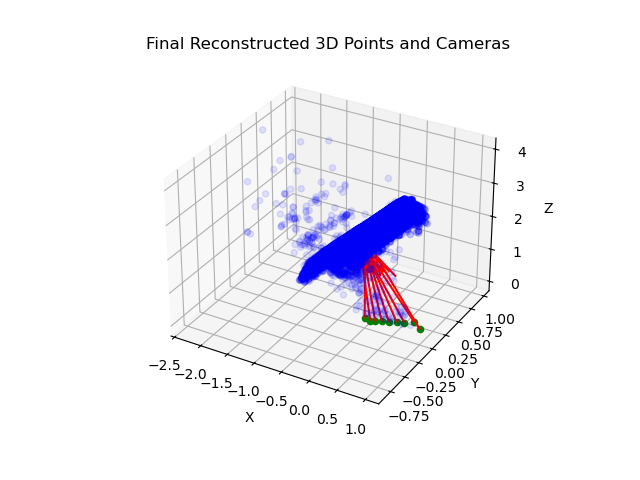

In [ ]:
#Final Visualization
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
X_to_plot=clean_point_cloud(X_recon)

ax.scatter(X_to_plot[0,:],X_to_plot[1,:],X_to_plot[2,:],c='b',marker='o',alpha=0.1)
for i in range(num_images):
    if all_cameras[i] is not None:
        plot_camera(all_cameras[i], scale=2.0, ax=ax)

ax.set_xlabel('X')  
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Final Reconstructed 3D Points and Cameras')

plt.show()

In [ ]:
#bundle adjustment   
all_cameras = run_motion_ba(X_recon, image_map, K, kp_list)

观测数据准备完毕: 75511 条
`ftol` termination condition is satisfied.
Function evaluations 720, initial cost 6.9507e+06, final cost 9.0491e+01, first-order optimality 4.33e+02.
开始优化...
------------------------------
优化是否成功: True
优化终止原因: `ftol` termination condition is satisfied.
迭代次数: 720
最终 Cost (误差): 90.4910
------------------------------
